In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import json
import pickle
import os

# from config import *
import scipy.sparse as sp


# Read Result Files

## 0) LP Result

## 1) Targeted Result

In [2]:
def get_file_name(exp_name, N_agents, deception_type, irl_type, number = 0):

    if irl_type == 'opt':
        file_name = exp_name +'_'+str(N_agents)+'_'+deception_type[:3] + '_opt.pkl'
    else:
        file_name = exp_name +'_'+str(N_agents)+'_'+deception_type[:3] + '_'+irl_type+'_'+str(number)+'.pkl'

    return file_name

In [3]:
deception_types = ['equivocal', 'targeted','diversionary']
irl_types = ['deep_maxent', 'maxent','apprenticeship']

num_irl = 100

experiments_name = {
     'diversionary': ['new_test0','new_test'],
     'targeted': ['final1','final12'],
     'equivocal': ['final','final12']
}

# beta_vec = {
#     'diversionary': {},
#     'targeted': {},
#     'equivocal': {}
# }

# results = {
#     'diversionary': {experiments_name['diversionary'][0] : {}, experiments_name['diversionary'][1] :{}},
#     'targeted':{experiments_name['targeted'][0] : {}, experiments_name['targeted'][1] : {}},
#     'equivocal':{experiments_name['equivocal'][0] : {}, experiments_name['equivocal'][1] : {}}
# }

N_agents = 5

In [4]:


# lp_file_name = 'result_'+str(N_agents)+'_lp.pkl'
# lp_str = os.path.abspath(os.path.join(os.path.abspath(os.path.curdir), lp_file_name))

# if lp_file_name[-3:] == 'pkl':
#     with open(lp_str, 'rb') as f:
#          exp_logger = pickle.load(f)
# else:
#     with open(lp_str, 'r') as f:
#         exp_logger = json.load(f)


# results['lp'] = exp_logger['results']


# for deception_type in deception_types:

#     for exp in experiments_name[deception_type]:

#         file_name = get_file_name(exp, N_agents, deception_type, 'opt')
#         save_str = os.path.abspath(os.path.join(os.path.abspath(os.path.curdir), file_name))

#         print("Reading", file_name)
#         if file_name[-3:] == 'pkl':
#             with open(save_str, 'rb') as f:
#                 exp_logger = pickle.load(f)
#         else:
#             with open(save_str, 'r') as f:
#                 exp_logger = json.load(f)

#         beta_vec[deception_type][exp] = exp_logger['beta_vec']
#         results[deception_type][exp]['opt'] = exp_logger['results']

#         for irl_type in irl_types:

#             irl_results = []

#             for k in tqdm(range(num_irl)):
#                 file_name = get_file_name(exp, N_agents, deception_type, irl_type, k)
#                 save_str = os.path.abspath(os.path.join(os.path.abspath(os.path.curdir), file_name))

#                 if file_name[-3:] == 'pkl':
#                     with open(save_str, 'rb') as f:
#                         exp_logger = pickle.load(f)
#                 else:
#                     with open(save_str, 'r') as f:
#                         exp_logger = json.load(f)

#                 irl_results.append([exp_logger['results'][i]['reward']['estimated_reward'] for i in range(len(exp_logger['results']))])

#             results[deception_type][exp][irl_type] = {
#                 'mean': np.mean(irl_results, axis = 0),
#                 'all': irl_results
#             } 


# results['beta_vec'] = beta_vec



In [5]:
# # Save average results
# save_file_name = "Final_combined_result_100.pkl" 
# save_str = os.path.abspath(os.path.join(os.path.abspath(os.path.curdir), save_file_name))
# with open(save_str, 'wb') as f:
#     pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
# print(save_file_name + " Saved")

In [6]:

save_file_name = "Final_combined_result_100.pkl" 
save_str = os.path.abspath(os.path.join(os.path.abspath(os.path.curdir), save_file_name))

with open(save_str, 'rb') as f:
      results = pickle.load(f)
beta_vec = results['beta_vec']


# Define Settings

In [7]:

N_agents = 5
n_local_states = 4
n_local_actions = 3
n_joint_states = n_local_states ** N_agents
n_joint_actions = n_local_actions ** N_agents

transitions = np.array(results['lp'][0]['transition_matrix'])
r = np.array(results['lp'][0]['reward']['reward'])
gamma = results['lp'][0]['config']['MMDP_SETTINGS']['gamma']
local_initial_state = results['lp'][0]['config']['MMDP_SETTINGS']['local_initial_state']
local_goal_state = results['lp'][0]['config']['MMDP_SETTINGS']['local_goal_state']

initial_distribution = np.zeros(n_joint_states)
initial_distribution[local_initial_state] = 1

# Performance Graph

## (1) Define performance bound

### Define functions

In [8]:

def find_the_joint_state(n_local_states, N_agents, agent, state):
    
    shape = (n_local_states,)*N_agents
    joint_states = np.zeros(shape)
    
    slices = [slice(None)] * N_agents
    slices[agent] = state  # Set the i-th dimension index to 0
    joint_states[tuple(slices)] = 1  # Fill the corresponding entries with 1
    
    joint_states = joint_states.flatten()
    joint_states_idx = np.where(joint_states==1)[0]
    
    return joint_states_idx

def determine_goal_decoy_states(n_local_states, N_agents, local_goal_state, real_agents = [0], target_decoy_agents = [1]):
    """
    Determine goal states and decoy states
    Goal states: When target agents are in "N(normal)" state
    Decoy states: When decoy agents are in "N(normal)" state 
    
    return: 1d array of goal states, 1d array of decoy states
    """
    goal_states = []
    decoy_states = []
    
    for i in real_agents:
        goal_states.extend(find_the_joint_state(n_local_states, N_agents, i, local_goal_state))
    for i in target_decoy_agents:
        decoy_states.extend(find_the_joint_state(n_local_states, N_agents, i, local_goal_state))
    
    return np.array(goal_states), np.array(decoy_states)


### Define variables

In [9]:
diversionary_bound_coefficients = [0,0]
targeted_bound_coefficients = [0,0]
equivocal_bound_coefficients = [0,0]

In [38]:

exp_num = 0
space_size = n_joint_states * n_joint_actions
R_star = results['lp'][0]['revenue']['revenue']

# Variables for diversionary bound
x_star = np.array(results['lp'][0]['occupancy_measure']['occupancy_measure'].cpu())
x_star_square_sum = np.sum([x**2 for x in x_star.flatten()])

# Variables for targeted bound
exp = experiments_name['targeted'][exp_num]
x_tar = np.array(results['targeted'][exp]['opt'][0]['occupancy_measure']['target_occupancy_measure'])
max_x_tar = np.max(x_tar)
min_x_tar = np.min(x_tar)
x_star_tar_cross_sum = np.sum(x_star*x_tar)

# Variables for equivocal bound
exp = experiments_name['equivocal'][exp_num]
real_agents = results['lp'][0]['config']['DECEPTION_SETTINGS']['real_agents']
target_decoy_agents = results['equivocal'][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['target_decoy_agents']

equ_coef = 0
x_star_s = np.sum(x_star.reshape(n_joint_states, n_joint_actions), axis = 1)
for r in real_agents:
    for t in target_decoy_agents:
        for s in range(n_local_states):
            goal_states, decoy_states = determine_goal_decoy_states(n_local_states, N_agents, s, [r], [t])
            x_sum_goal = np.sum(x_star_s[goal_states])
            x_sum_decoy = np.sum(x_star_s[decoy_states])
            equ_coef += ((x_sum_goal - x_sum_decoy)**2)


print(x_sum_goal, x_sum_decoy)

diversionary_bound_coefficients[exp_num] = (x_star_square_sum + (1-gamma)**(-2))/R_star
targeted_bound_coefficients[exp_num] = (x_star_square_sum - 2*x_star_tar_cross_sum -(1/space_size)*((1-gamma)**(-2))+2*(max_x_tar - min_x_tar)/(1-gamma))/R_star
equivocal_bound_coefficients[exp_num] = equ_coef/R_star


0.06886437 0.07575769


/tmp/ipykernel_1892838/1189647528.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_star = np.array(results['lp'][0]['occupancy_measure']['occupancy_measure'].cpu())


In [40]:

exp_num = 1
space_size = n_joint_states * n_joint_actions
R_star = results['lp'][0]['revenue']['revenue']
x_star = np.array(results['lp'][0]['occupancy_measure']['occupancy_measure'].cpu())
x_star_square_sum = np.sum([x**2 for x in x_star.flatten()])

# Variables for diversionary bound
exp = experiments_name['diversionary'][exp_num]
R_star_div = results['diversionary'][exp]['opt'][0]['revenue']['revenue']
x_star_div = np.array(results['diversionary'][exp]['opt'][0]['occupancy_measure']['occupancy_measure'].cpu())
x_star_square_sum_div = np.sum([x**2 for x in x_star_div.flatten()])

# Variables for targeted bound
exp = experiments_name['targeted'][exp_num]
x_tar = np.array(results['targeted'][exp]['opt'][0]['occupancy_measure']['target_occupancy_measure'])
max_x_tar = np.max(x_tar)
min_x_tar = np.min(x_tar)
x_star_tar_cross_sum = np.sum(x_star*x_tar)

# Variables for equivocal bound
exp = experiments_name['equivocal'][exp_num]
real_agents = results['lp'][0]['config']['DECEPTION_SETTINGS']['real_agents']
target_decoy_agents = results['equivocal'][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['target_decoy_agents']
equ_coef = 0
x_star_s = np.sum(x_star.reshape(n_joint_states, n_joint_actions), axis = 1)
for r in real_agents:
    for t in target_decoy_agents:
        for s in range(n_local_states):
            goal_states, decoy_states = determine_goal_decoy_states(n_local_states, N_agents, s, [r], [t])
            x_sum_goal = np.sum(x_star_s[goal_states])
            x_sum_decoy = np.sum(x_star_s[decoy_states])
            equ_coef += ((x_sum_goal - x_sum_decoy)**2)


print(x_sum_goal, x_sum_decoy)

diversionary_bound_coefficients[exp_num] = (x_star_square_sum_div + (1-gamma)**(-2))/R_star_div
targeted_bound_coefficients[exp_num] = (x_star_square_sum - 2*x_star_tar_cross_sum -(1/space_size)*((1-gamma)**(-2))+2*(max_x_tar - min_x_tar)/(1-gamma))/R_star
equivocal_bound_coefficients[exp_num] = equ_coef/R_star


0.06886437 0.075757675


/tmp/ipykernel_1892838/1168970596.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_star = np.array(results['lp'][0]['occupancy_measure']['occupancy_measure'].cpu())
/tmp/ipykernel_1892838/1168970596.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_star_div = np.array(results['diversionary'][exp]['opt'][0]['occupancy_measure']['occupancy_measure'].cpu())


In [ ]:
print(x_star_square_sum, x_star_square_sum_div)

8.478972 8.478972


In [65]:
12**5

248832

### Compute Coefficients

In [41]:
print(diversionary_bound_coefficients)
print(targeted_bound_coefficients)
print(equivocal_bound_coefficients)

[np.float32(0.82431966), np.float32(0.82431966)]
[np.float64(0.6286611001748368), np.float64(1.1928944796192722)]
[np.float32(0.00041717477), np.float32(0.0008343476)]


In [73]:
print(0.20/0.82431966)
print(0.15/0.6286611001748368)
print(0.20/1.1928944796192722)
print(0.15/0.00041717477)
print(0.20/0.0008343476)

0.24262432367559936
0.23860232477925472
0.16765942287186425
359.56153340720965
239.70824629926423


## (2) Make Plot

diversionary [100.0, 99.01985270194464, 99.00693588831153, 98.98012828227945, 98.03599500859073, 98.03678346759168, 97.44807127854888, 97.44059251302522, 97.36285973152043, 97.05910010391425, 97.05878703931094]
targeted [100.0, 99.94621086939306, 99.93852339502521, 99.91373331931113, 99.91118242283915, 99.82032412850072, 99.69368371365074, 99.60321964876707, 99.51389189231182, 99.42855281034004, 99.36110478862402]
equivocal [100.0, 99.98763974566168, 99.98774410052945, 99.98770931557353, 99.98776729050006, 99.98775569551476, 99.98760496070575, 99.98759336572046, 99.9876745306176, 99.98766293563229, 99.98768612560292]
diversionary [100.0, 99.44986766709543, 99.44474510304751, 99.44473804717416, 99.06539312856718, 99.0657953133478, 97.96690654284079, 97.8878031467784, 97.88686471562362, 97.86189397985831, 97.86186575636494]
targeted [100.0, 99.89877578999814, 99.88367912087759, 99.84920723355394, 99.83251045664642, 99.64242228954785, 99.51130621088794, 99.40551357720445, 99.3082084717822

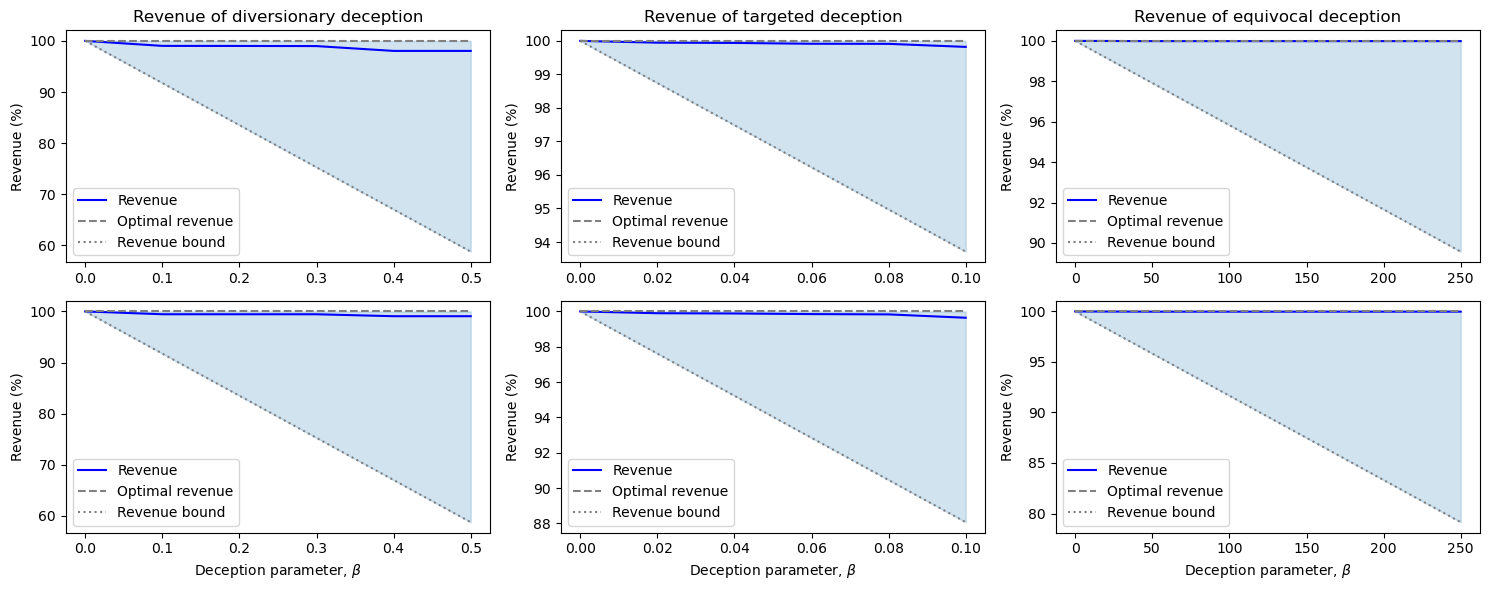

In [69]:


# Create horizontal subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 1 row, 2 columns

# Loop through each subplot (they’ll show the same thing)


deception_type_list = ['diversionary','targeted','equivocal']

cutoff = 6

for e in range(2):

    for j in range(len(deception_type_list)):

        ax = axes[e,j]
        deception_type = deception_type_list[j]
        
        exp = experiments_name[deception_type][e]

        if deception_type == "diversionary":
            coef = diversionary_bound_coefficients[e]
        elif deception_type == "targeted":
            coef = targeted_bound_coefficients[e]
        elif deception_type == "equivocal":
            coef = equivocal_bound_coefficients[e]


        standard = results[deception_type][exp]['opt'][0]['revenue']['deceptive_revenue']

        betas = np.array(beta_vec[deception_type][exp])
        deceptive_revenue = [results[deception_type][exp]['opt'][i]['revenue']['deceptive_revenue']/standard*100 for i in range(len(results[deception_type][exp]['opt']))]

        print(deception_type, deceptive_revenue)

        # deceptive_revenue[0] = 100

        
        ax.plot(betas[:cutoff], deceptive_revenue[:cutoff], label='Revenue', c='b')
        ax.plot(betas[:cutoff], 100*np.ones(betas.shape)[:cutoff], '--', label='Optimal revenue', c='gray')
        ax.plot(betas[:cutoff], 100*(np.ones(betas.shape)-coef*betas)[:cutoff], ':', label='Revenue bound', c='gray')
        ax.fill_between(betas[:cutoff], 
                        100*(np.ones(betas.shape)-coef*betas)[:cutoff], 
                        100, 
                        where=100 >= 100*(np.ones(betas.shape)-coef*betas)[:cutoff], 
                        color='C0', alpha=0.2, interpolate=True)
        if e== 0:
            ax.set_title('Revenue of ' + deception_type_list[j] + ' deception')
        else:
            ax.set_xlabel("Deception parameter, $\\beta$")
        ax.set_ylabel('Revenue (%)')
        ax.legend()

plt.tight_layout()
plt.show()


# Deceptiveness Graph

## Compare Marginal Rewards

In [47]:
def calculate_weighted_marginal_rewards(rewards, n_states, N_agents):
    shape = (n_states,)*N_agents

    r = [0] * N_agents
    
    for i in range(N_agents):
        axis = list(range(N_agents))
        axis.remove(i)

        marginal_rewards = np.apply_over_axes(np.sum, rewards.reshape(shape), axis).flatten()

        r[i] = 1*marginal_rewards[0] + 0.75*marginal_rewards[1] + 0.5*marginal_rewards[2] + 0.25*marginal_rewards[3]
        
        
    return r

## 1) Generate Marginal Reward Data

In [48]:
# TRUE REWARDS
true_rewards = [np.sum(np.array(results['lp'][i]['reward']['reward']).reshape(n_joint_states,n_joint_actions),axis = 1) for i in range(len(results['lp']))]
standard = calculate_weighted_marginal_rewards(true_rewards[0], n_local_states, N_agents)[0]
    


In [56]:
def deception_metric_to_likelihood(metrics, temperature = 1):
    """
    Compute likelihood over agents from deception metric using softmax

    Input:
    metrics: np.array of shape (N_agents, num_data)

    Output:
    likelihood: np.array of shape (N_agents, num_data)
    """
    metrics = np.array(metrics)
    scaled_metrics = metrics / temperature
    # subtract row-wise max for numerical stability
    max = np.max(scaled_metrics, axis=0, keepdims=True)
    exp_metrics = np.exp(scaled_metrics - max)
    return exp_metrics / np.sum(exp_metrics, axis=0, keepdims=True)


def likelihood_data_from_rewards(rewards, n_local_states, N_agents, standard, temperature = 0.01):
    
    num_data, _ = rewards.shape
    metric_data = np.zeros((N_agents, num_data))
    
    for j in range(N_agents):
        metric_data[j,:] = np.array([calculate_weighted_marginal_rewards(rewards[i], n_local_states,N_agents)[j]/standard for i in range(num_data)])
        
    likelihood = deception_metric_to_likelihood(metric_data, temperature= temperature)
    
    return likelihood

[0] [1]
[0] [1]
[0] [1]


/tmp/ipykernel_1892838/119327191.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


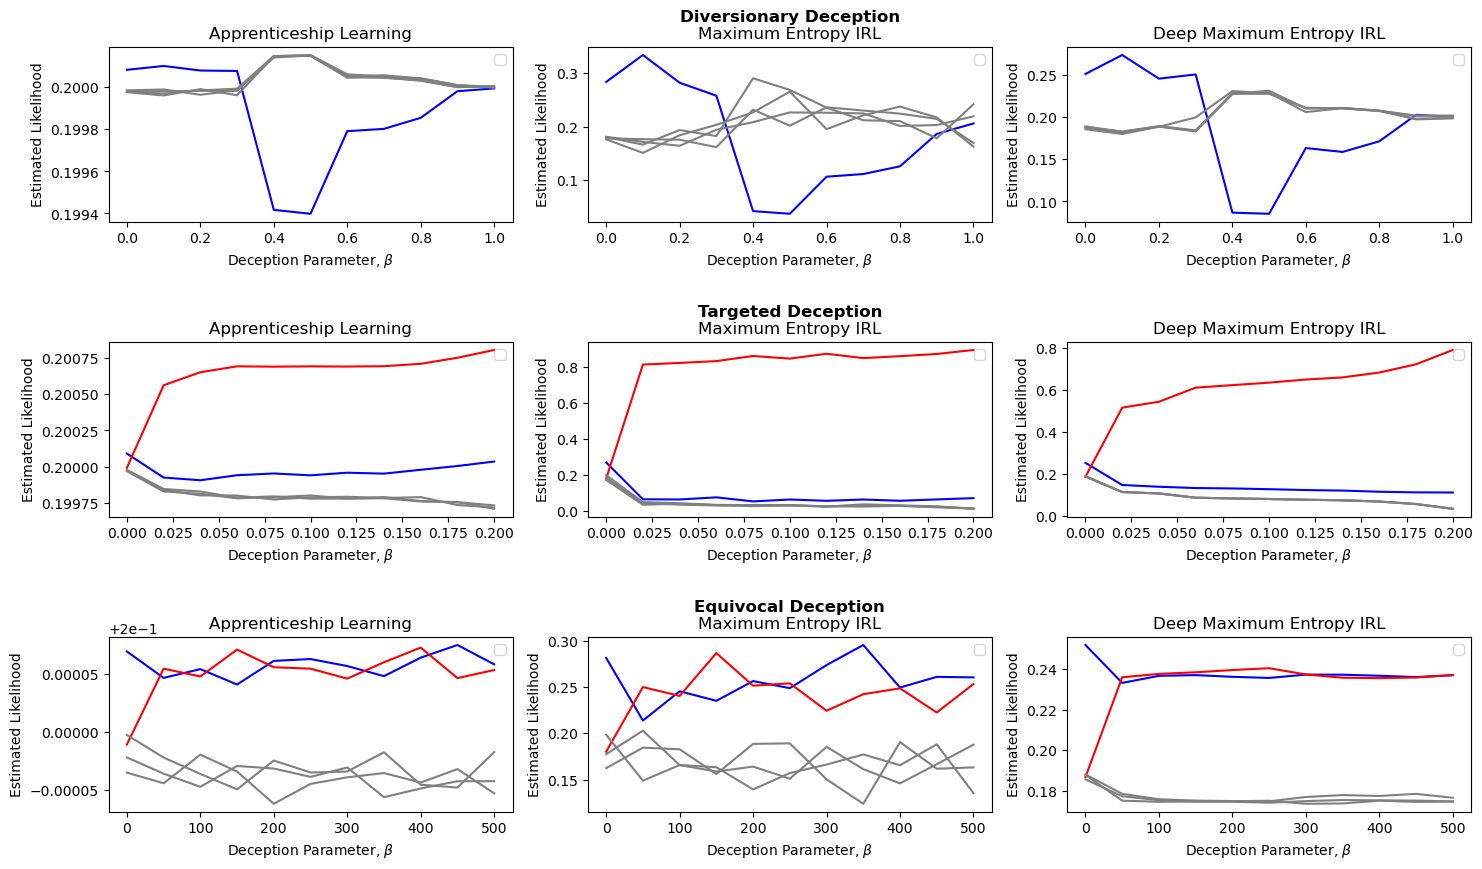

In [50]:

from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

standard = results['lp'][0]['revenue']['revenue']

# Create horizontal subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 9))  # 1 row, 2 columns

# Loop through each subplot (they’ll show the same thing)

IRL_type_list = ['apprenticeship','maxent','deep_maxent']
deception_type_list = ['diversionary','targeted','equivocal']


    
for (r, deception_type) in enumerate(deception_type_list):

    exp = experiments_name[deception_type][0]

    real_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['real_agents']
    target_decoy_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['target_decoy_agents']
    print(real_agents, target_decoy_agents)
    

    for (c, irl_type) in enumerate(IRL_type_list):
        
        ax = axes[r,c]

        betas = np.array(beta_vec[deception_type][exp])
            
        rewards = np.array([np.sum(np.array(results[deception_type][exp][irl_type]['mean'][i]).reshape(n_joint_states,n_joint_actions),axis = 1) 
                   for i in range(len(results[deception_type][exp][irl_type]['mean']))])
        
        likelihood = likelihood_data_from_rewards(rewards, n_local_states, N_agents, standard, temperature = 1)
        
        for i in range(N_agents):
            if i in real_agents:
                ax.plot(betas, likelihood[i,:], c = 'blue')
            elif i in target_decoy_agents:
                if deception_type == 'diversionary':
                    ax.plot(betas, likelihood[i,:], c = 'gray')
                else:
                    ax.plot(betas, likelihood[i,:], c = 'red')
            else:
                if deception_type == 'diversionary':
                    ax.plot(betas, likelihood[i,:], c = 'gray')
                else:
                    ax.plot(betas, likelihood[i,:], c = 'gray')
        
        ax.set_xlabel("Deception Parameter, $\\beta$")
        ax.set_ylabel("Estimated Likelihood")
        ax.legend()
        
        if irl_type == 'apprenticeship':
            ax.set_title("Apprenticeship Learning")
        elif irl_type == 'maxent':
            ax.set_title("Maximum Entropy IRL")
        else:
            ax.set_title("Deep Maximum Entropy IRL")


grid = plt.GridSpec(3, 3)
create_subtitle(fig, grid[0, ::], 'Diversionary Deception')
create_subtitle(fig, grid[1, ::], 'Targeted Deception')
create_subtitle(fig, grid[2, ::], 'Equivocal Deception')

plt.tight_layout()
plt.show()


[0, 1] [2]
[0] [1, 2]
[0] [1, 2]


/tmp/ipykernel_1892838/1416304823.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


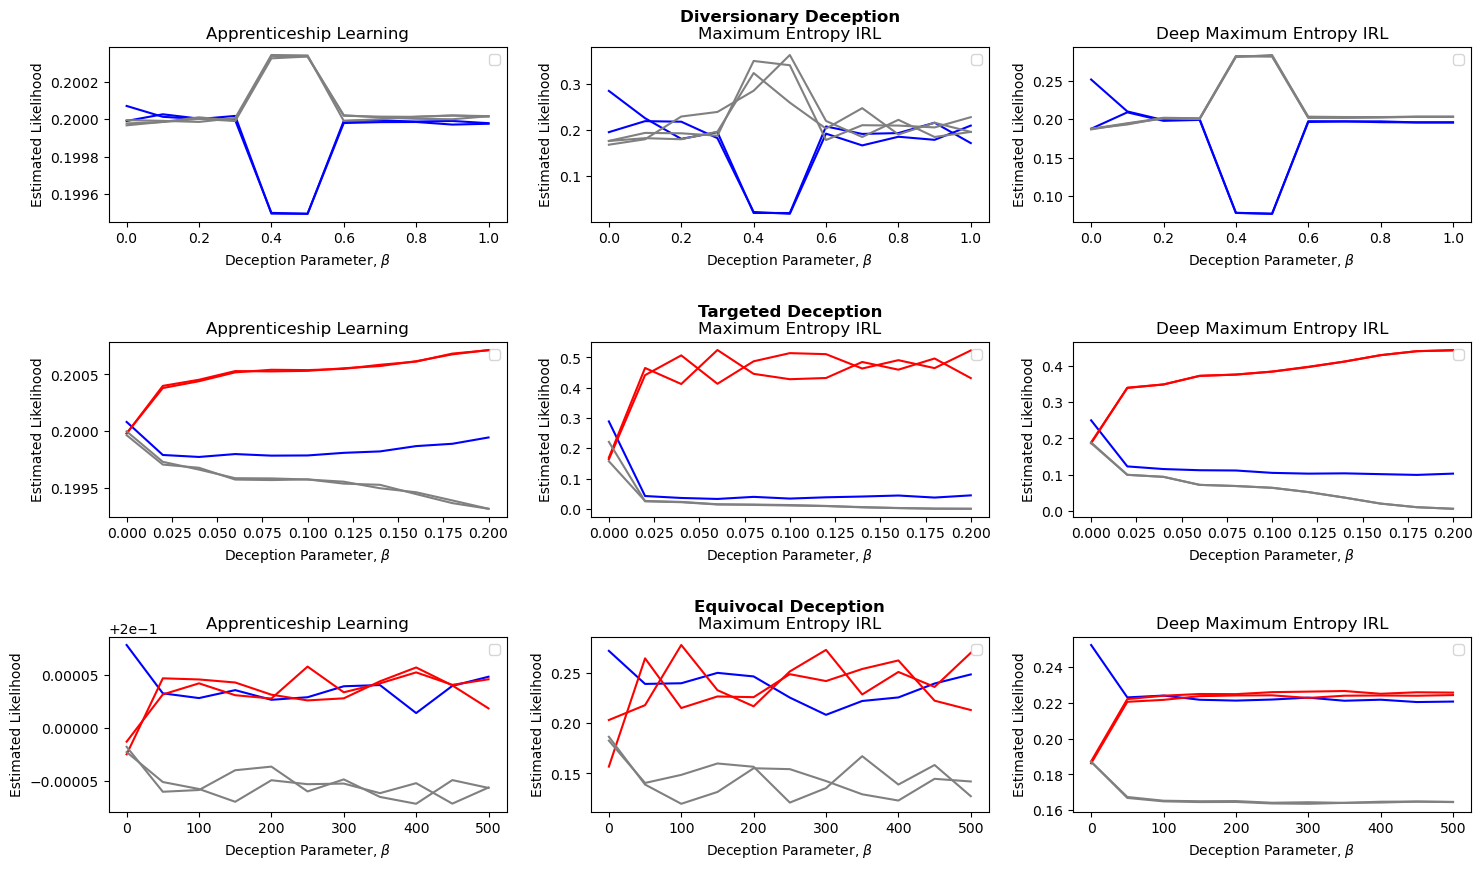

In [51]:

from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

standard = results['lp'][0]['revenue']['revenue']

# Create horizontal subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 9))  


IRL_type_list = ['apprenticeship','maxent','deep_maxent']
deception_type_list = ['diversionary','targeted','equivocal']


    
for (r, deception_type) in enumerate(deception_type_list):

    exp = experiments_name[deception_type][1]

    real_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['real_agents']
    target_decoy_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['target_decoy_agents']
    print(real_agents, target_decoy_agents)
    

    for (c, irl_type) in enumerate(IRL_type_list):
        
        ax = axes[r,c]

        betas = np.array(beta_vec[deception_type][exp])
            
            
        rewards = np.array([np.sum(np.array(results[deception_type][exp][irl_type]['mean'][i]).reshape(n_joint_states,n_joint_actions),axis = 1) 
                   for i in range(len(results[deception_type][exp][irl_type]['mean']))])
        
        likelihood = likelihood_data_from_rewards(rewards, n_local_states, N_agents, standard, temperature = 1)
        
        for i in range(N_agents):
            if i in real_agents:
                ax.plot(betas, likelihood[i,:], c = 'blue')
            elif i in target_decoy_agents:
                if deception_type == 'diversionary':
                    ax.plot(betas, likelihood[i,:], c = 'gray')
                else:
                    ax.plot(betas, likelihood[i,:], c = 'red')
            else:
                if deception_type == 'diversionary':
                    ax.plot(betas, likelihood[i,:], c = 'gray')
                else:
                    ax.plot(betas, likelihood[i,:], c = 'gray')
        
        ax.set_xlabel("Deception Parameter, $\\beta$")
        ax.set_ylabel("Estimated Likelihood")
        ax.legend()
        
        if irl_type == 'apprenticeship':
            ax.set_title("Apprenticeship Learning")
        elif irl_type == 'maxent':
            ax.set_title("Maximum Entropy IRL")
        else:
            ax.set_title("Deep Maximum Entropy IRL")


grid = plt.GridSpec(3, 3)
create_subtitle(fig, grid[0, ::], 'Diversionary Deception')
create_subtitle(fig, grid[1, ::], 'Targeted Deception')
create_subtitle(fig, grid[2, ::], 'Equivocal Deception')

plt.tight_layout()
plt.show()


[0] [1]
[0, 1] [2]


/tmp/ipykernel_1892838/2505359889.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


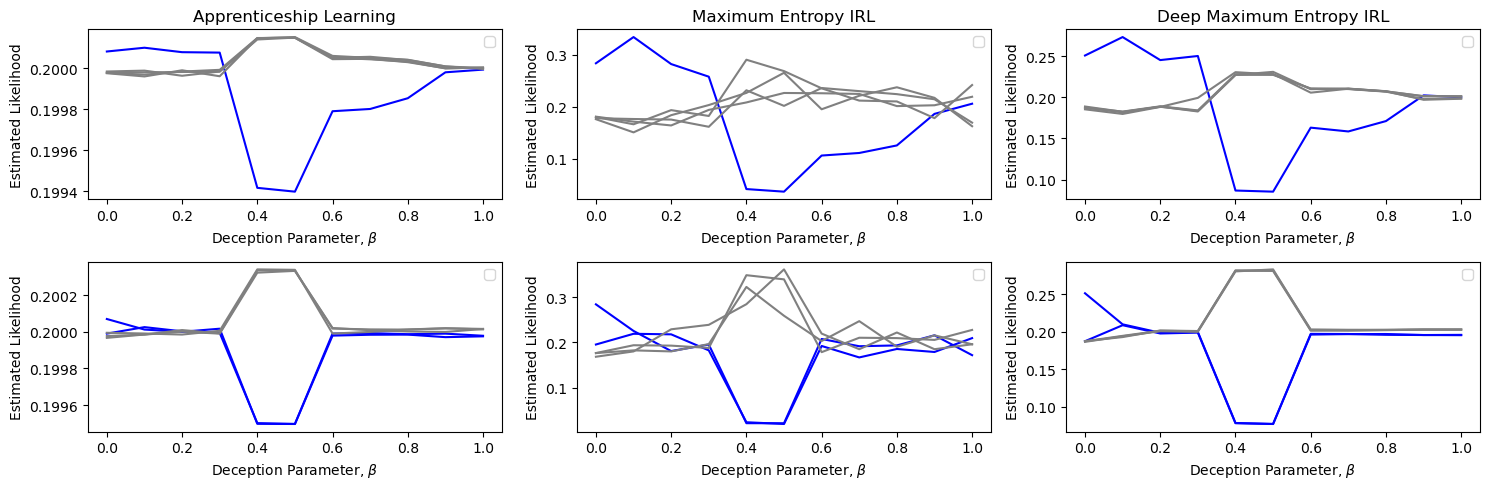

In [52]:

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

standard = results['lp'][0]['revenue']['revenue']

# Create horizontal subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 5))  


IRL_type_list = ['apprenticeship','maxent','deep_maxent']
deception_type_list = ['diversionary','targeted','equivocal']

deception_type = "diversionary"
    
for r in range(2):

    exp = experiments_name[deception_type][r]

    real_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['real_agents']
    target_decoy_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['target_decoy_agents']
    print(real_agents, target_decoy_agents)
    

    for (c, irl_type) in enumerate(IRL_type_list):
        
        ax = axes[r,c]

        betas = np.array(beta_vec[deception_type][exp])
            
        rewards = np.array([np.sum(np.array(results[deception_type][exp][irl_type]['mean'][i]).reshape(n_joint_states,n_joint_actions),axis = 1) 
                   for i in range(len(results[deception_type][exp][irl_type]['mean']))])
        
        likelihood = likelihood_data_from_rewards(rewards, n_local_states, N_agents, standard, temperature = 1)
        
        for i in range(N_agents):
            if i in real_agents:
                ax.plot(betas, likelihood[i,:], c = 'blue')
            elif i in target_decoy_agents:
                if deception_type == 'diversionary':
                    ax.plot(betas, likelihood[i,:], c = 'gray')
                else:
                    ax.plot(betas, likelihood[i,:], c = 'red')
            else:
                if deception_type == 'diversionary':
                    ax.plot(betas, likelihood[i,:], c = 'gray')
                else:
                    ax.plot(betas, likelihood[i,:], c = 'gray')
        
        ax.set_xlabel("Deception Parameter, $\\beta$")
        ax.set_ylabel("Estimated Likelihood")
        ax.legend()

        if r==0:
            if irl_type == 'apprenticeship':
                ax.set_title("Apprenticeship Learning")
            elif irl_type == 'maxent':
                ax.set_title("Maximum Entropy IRL")
            else:
                ax.set_title("Deep Maximum Entropy IRL")


# grid = plt.GridSpec(3, 3)
# create_subtitle(fig, grid[0, ::], 'Diversionary Deception')
# create_subtitle(fig, grid[1, ::], 'Targeted Deception')
# create_subtitle(fig, grid[2, ::], 'Equivocal Deception')

plt.tight_layout()
plt.show()


[0] [1]
[0] [1, 2]


/tmp/ipykernel_1892838/3997105727.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


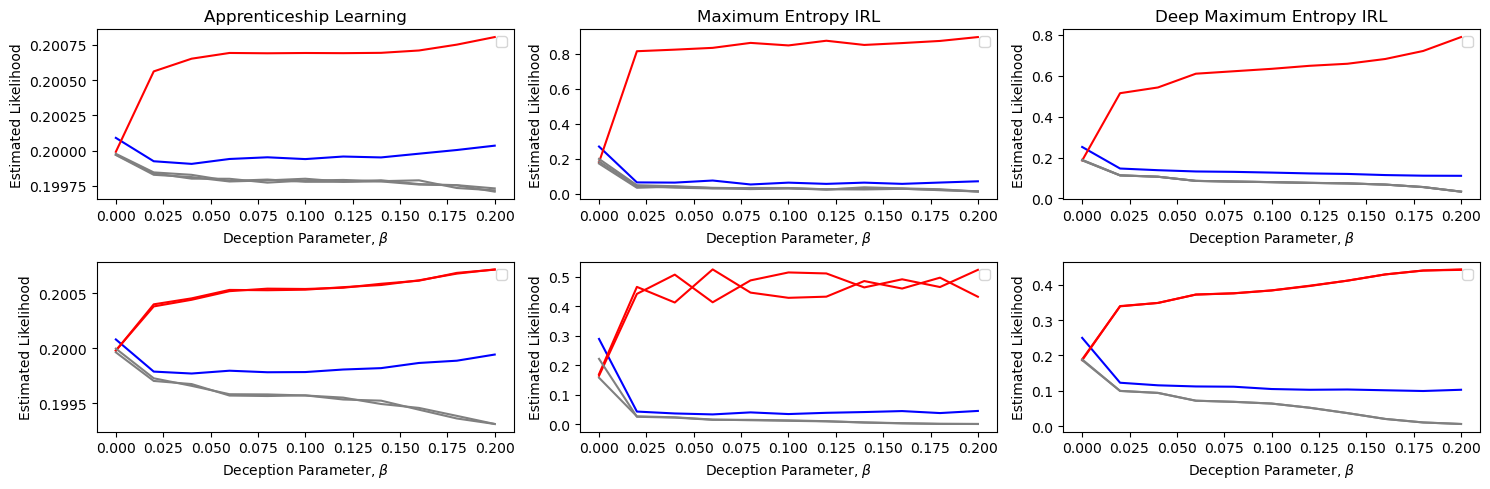

In [53]:

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

standard = results['lp'][0]['revenue']['revenue']

# Create horizontal subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 5))  


IRL_type_list = ['apprenticeship','maxent','deep_maxent']
deception_type_list = ['diversionary','targeted','equivocal']

deception_type = "targeted"
    
for r in range(2):

    exp = experiments_name[deception_type][r]

    real_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['real_agents']
    target_decoy_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['target_decoy_agents']
    print(real_agents, target_decoy_agents)
    

    for (c, irl_type) in enumerate(IRL_type_list):
        
        ax = axes[r,c]

        betas = np.array(beta_vec[deception_type][exp])
            
            
        rewards = np.array([np.sum(np.array(results[deception_type][exp][irl_type]['mean'][i]).reshape(n_joint_states,n_joint_actions),axis = 1) 
                   for i in range(len(results[deception_type][exp][irl_type]['mean']))])
        
        likelihood = likelihood_data_from_rewards(rewards, n_local_states, N_agents, standard, temperature = 1)
        
        for i in range(N_agents):
            if i in real_agents:
                ax.plot(betas, likelihood[i,:], c = 'blue')
            elif i in target_decoy_agents:
                if deception_type == 'diversionary':
                    ax.plot(betas, likelihood[i,:], c = 'gray')
                else:
                    ax.plot(betas, likelihood[i,:], c = 'red')
            else:
                if deception_type == 'diversionary':
                    ax.plot(betas, likelihood[i,:], c = 'gray')
                else:
                    ax.plot(betas, likelihood[i,:], c = 'gray')
        
        ax.set_xlabel("Deception Parameter, $\\beta$")
        ax.set_ylabel("Estimated Likelihood")
        ax.legend()

        if r==0:
            if irl_type == 'apprenticeship':
                ax.set_title("Apprenticeship Learning")
            elif irl_type == 'maxent':
                ax.set_title("Maximum Entropy IRL")
            else:
                ax.set_title("Deep Maximum Entropy IRL")


# grid = plt.GridSpec(3, 3)
# create_subtitle(fig, grid[0, ::], 'Diversionary Deception')
# create_subtitle(fig, grid[1, ::], 'Targeted Deception')
# create_subtitle(fig, grid[2, ::], 'Equivocal Deception')

plt.tight_layout()
plt.show()


[0] [1]
[0] [1, 2]


/tmp/ipykernel_1892838/32128750.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


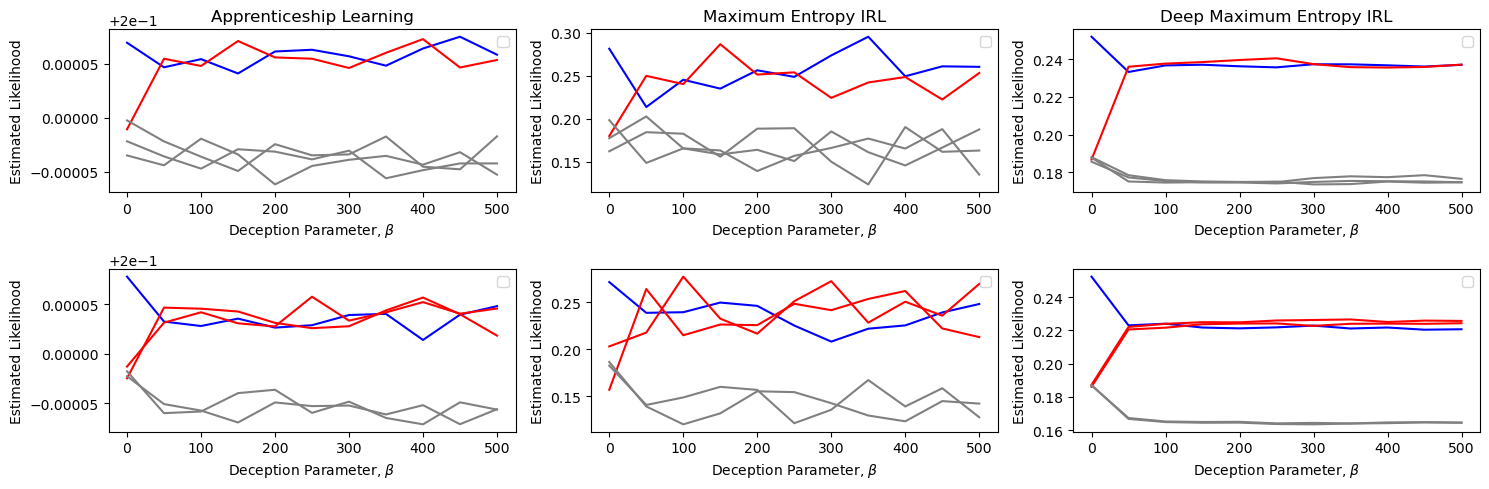

In [54]:

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

standard = results['lp'][0]['revenue']['revenue']

# Create horizontal subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 5))  


IRL_type_list = ['apprenticeship','maxent','deep_maxent']
deception_type_list = ['diversionary','targeted','equivocal']

deception_type = "equivocal"
    
for r in range(2):

    exp = experiments_name[deception_type][r]

    real_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['real_agents']
    target_decoy_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['target_decoy_agents']
    print(real_agents, target_decoy_agents)
    

    for (c, irl_type) in enumerate(IRL_type_list):
        
        ax = axes[r,c]

        betas = np.array(beta_vec[deception_type][exp])
            
            
        rewards = np.array([np.sum(np.array(results[deception_type][exp][irl_type]['mean'][i]).reshape(n_joint_states,n_joint_actions),axis = 1) 
                   for i in range(len(results[deception_type][exp][irl_type]['mean']))])
        
        likelihood = likelihood_data_from_rewards(rewards, n_local_states, N_agents, standard, temperature = 1)
        
        for i in range(N_agents):
            if i in real_agents:
                ax.plot(betas, likelihood[i,:], c = 'blue')
            elif i in target_decoy_agents:
                if deception_type == 'diversionary':
                    ax.plot(betas, likelihood[i,:], c = 'gray')
                else:
                    ax.plot(betas, likelihood[i,:], c = 'red')
            else:
                if deception_type == 'diversionary':
                    ax.plot(betas, likelihood[i,:], c = 'gray')
                else:
                    ax.plot(betas, likelihood[i,:], c = 'gray')
        
        ax.set_xlabel("Deception Parameter, $\\beta$")
        ax.set_ylabel("Estimated Likelihood")
        ax.legend()

        if r==0:
            if irl_type == 'apprenticeship':
                ax.set_title("Apprenticeship Learning")
            elif irl_type == 'maxent':
                ax.set_title("Maximum Entropy IRL")
            else:
                ax.set_title("Deep Maximum Entropy IRL")


# grid = plt.GridSpec(3, 3)
# create_subtitle(fig, grid[0, ::], 'Diversionary Deception')
# create_subtitle(fig, grid[1, ::], 'Targeted Deception')
# create_subtitle(fig, grid[2, ::], 'Equivocal Deception')

plt.tight_layout()
plt.show()


## Utility

In [55]:
results['diversionary']['new_test0']['opt'][0]['config']['DECEPTION_SETTINGS']['target_decoy_agents'] = []
results['diversionary']['new_test']['opt'][0]['config']['DECEPTION_SETTINGS']['target_decoy_agents'] = []

In [60]:
adversary_utility = np.zeros((3,3,2,11))  # deception_type, irl_type, exp, beta

def calculate_utility(estimated_target, real_agents, target_decoy_agents):

    if estimated_target in real_agents:
        return 1
    elif estimated_target in target_decoy_agents:
        return -1
    else:
        return 0

IRL_type_list = ['deep_maxent']
deception_type_list = ['diversionary','targeted','equivocal']

standard = results['lp'][0]['revenue']['revenue']
    
for (r, deception_type) in enumerate(deception_type_list): 

    for (c, irl_type) in enumerate(IRL_type_list):

        for e in range(2):
            
            exp = experiments_name[deception_type][e]

            real_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['real_agents']
            target_decoy_agents = results[deception_type][exp]['opt'][0]['config']['DECEPTION_SETTINGS']['target_decoy_agents']   

            print(deception_type, irl_type, exp)

            estimated_target_counts = np.zeros((N_agents, len(beta_vec[deception_type][exp])))

            for k in range(100):

                rewards = np.array([np.sum(np.array(results[deception_type][exp][irl_type]['all'][k][i]).reshape(n_joint_states,n_joint_actions),axis = 1) 
                        for i in range(len(results[deception_type][exp][irl_type]['all'][k]))])
                
        
                likelihood = likelihood_data_from_rewards(rewards, n_local_states, N_agents, standard, temperature = 1)

                estimated_target = np.argmax(np.array(likelihood), axis = 0)
                for (b,et) in enumerate(estimated_target):
                    estimated_target_counts[et,b] += 1

                adversary_utility[r,c,e] += [calculate_utility(et, real_agents, target_decoy_agents) for et in estimated_target]


            print(estimated_target_counts)
            print(adversary_utility[r,c,e])
                
                

diversionary deep_maxent new_test0
[[100. 100. 100. 100.   0.   0.   5.   2.   0.  42.  22.]
 [  0.   0.   0.   0.  34.  17.  26.  18.  18.  30.  28.]
 [  0.   0.   0.   0.  21.  13.  22.  17.  22.   5.  12.]
 [  0.   0.   0.   0.  20.   8.  23.  30.  31.   3.   8.]
 [  0.   0.   0.   0.  25.  62.  24.  33.  29.  20.  30.]]
[100. 100. 100. 100.   0.   0.   5.   2.   0.  42.  22.]
diversionary deep_maxent new_test
[[100.  45.  19.  16.   0.   0.  16.   7.   3.   1.   1.]
 [  0.  47.  14.  18.   0.   0.  12.   7.   2.   3.   3.]
 [  0.   2.  23.  25.  35.  36.  31.  41.  44.  33.  32.]
 [  0.   3.  21.  20.  38.  28.  20.  26.  35.  34.  34.]
 [  0.   3.  23.  21.  27.  36.  21.  19.  16.  29.  30.]]
[100.  92.  33.  34.   0.   0.  28.  14.   5.   4.   4.]
targeted deep_maxent final1
[[ 99.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   0.   0.   0.   0.   0.  

In [ ]:
# Save average results
save_file_name = "Final_utility_100.pkl" 
save_str = os.path.abspath(os.path.join(os.path.abspath(os.path.curdir), save_file_name))
with open(save_str, 'wb') as f:
    pickle.dump(adversary_utility, f, protocol=pickle.HIGHEST_PROTOCOL)
print(save_file_name + " Saved")

Final_utility_100.pkl Saved
